  1%|▋                                                              | 1/100 [00:05<08:53,  5.39s/it]


ELBO @   1 : -8.8772e+01


 25%|███████████████▌                                              | 25/100 [02:06<06:17,  5.04s/it]


ELBO @  25 : -2.8369e+00


 50%|███████████████████████████████                               | 50/100 [04:04<03:53,  4.66s/it]


ELBO @  50 : -3.7735e-01


 75%|██████████████████████████████████████████████▌               | 75/100 [05:27<01:22,  3.31s/it]


ELBO @  75 : 2.2745e-01


100%|█████████████████████████████████████████████████████████████| 100/100 [06:47<00:00,  4.07s/it]


ELBO @ 100 : 5.7400e-01


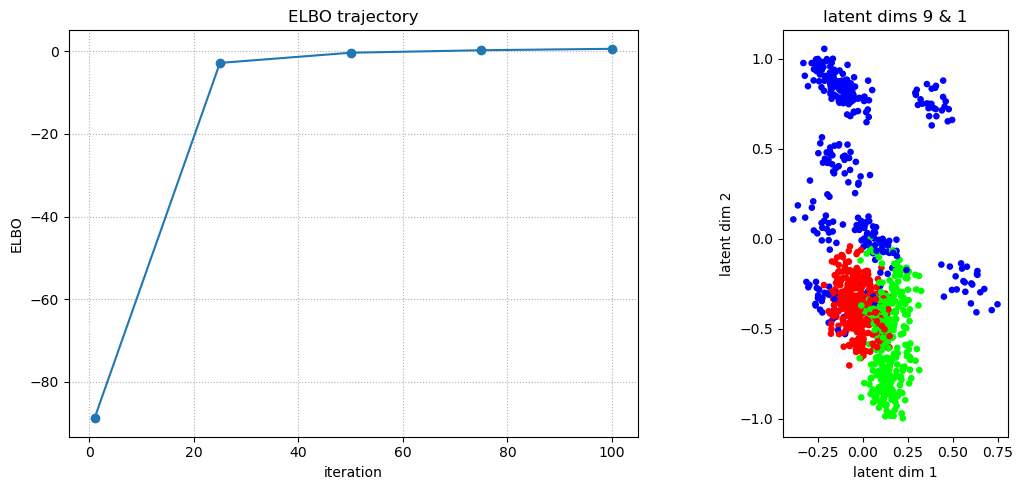

In [1]:
import math, tarfile, urllib.request, numpy as np, matplotlib.pyplot as plt, torch
from pathlib import Path
from tqdm import trange
from sklearn.decomposition import PCA
torch.set_default_dtype(torch.float64)

# --------------------------- misc -----------------------------------
DEV = "cuda" if torch.cuda.is_available() else "cpu"
DEBUG = False                          # print shapes in first outer iter
LR_X, LR_HYP = 5e-3, 5e-3
BATCH, T_TOTAL, INNER0, INNER = 128, 100, 30, 20
JITTER, MAX_EXP, CLIP_QUAD, GR_CLIP = 5e-6, 60.0, 1e6, 10.0
BOUNDS = {"log_sf2": (-5.0, 6.0), "log_alpha": (-8.0, 8.0),
          "log_beta": (-8.0, 5.0), "log_s2x": (-8.0, 8.0)}

rho = lambda t, t0=100.0, k=0.6: (t0 + t) ** (-k)          # SVI step size
safe_exp = lambda x: torch.exp(torch.clamp(x, max=MAX_EXP))

def cholesky_safe(mat, eps=1e-6):                          # mat (., M, M)
    eye = torch.eye(mat.size(-1), device=mat.device, dtype=mat.dtype)
    try:
        return torch.linalg.cholesky(mat + eps * eye)      # (., M, M)
    except RuntimeError:
        eig_val, eig_vec = torch.linalg.eigh(mat)          # (., M), (., M, M)
        eig_val = torch.clamp(eig_val, min=eps)
        return eig_vec @ torch.diag_embed(torch.sqrt(eig_val))   # (., M, M)

# --------------------------- data -----------------------------------
root = Path("oil_data"); root.mkdir(exist_ok=True)
url  = "http://staffwww.dcs.shef.ac.uk/people/N.Lawrence/resources/3PhData.tar.gz"
arc  = root / "3PhData.tar.gz"
if not arc.exists():
    urllib.request.urlretrieve(url, arc)
with tarfile.open(arc) as tar:
    tar.extract("DataTrn.txt",     path=root)
    tar.extract("DataTrnLbls.txt", path=root)

Y_np   = np.loadtxt(root / "DataTrn.txt")                  # (N, D)
lbl_np = np.loadtxt(root / "DataTrnLbls.txt").astype(int)  # (N,)
Y      = torch.tensor(Y_np,  device=DEV)                   # (N, D)
lbl    = torch.tensor(lbl_np, device=DEV)                  # (N,)
N, D   = Y.shape                                           # N=846, D=12
Q = D

# ----------------------- latent variables ---------------------------
Y_std = (Y_np - Y_np.mean(0)) / Y_np.std(0)
mu_x    = torch.tensor(PCA(Q).fit_transform(Y_std),
                       device=DEV, requires_grad=True)     # (N, Q)
log_s2x = torch.full_like(mu_x, -2.0, requires_grad=True)  # (N, Q)

# ------------------- kernel & inducing inputs -----------------------
M = 64
perm = torch.randperm(N, device=DEV)[:M]
Z = mu_x.detach()[perm].clone().requires_grad_(True)                     # (M=64, Q)


log_sf2      = torch.tensor(math.log(Y_np.var()),  device=DEV, requires_grad=True)  # ()
log_alpha = (torch.full((Q,), -2.0, device=DEV)
             + 0.1 * torch.randn(Q, device=DEV)
            ).requires_grad_()   # (Q,)
log_beta_inv = torch.tensor(-3.2, device=DEV, requires_grad=True)  # ()

def k_se(x, z, log_sf2_val, log_alpha_val):
    sf2   = safe_exp(log_sf2_val)                           # ()
    alpha = safe_exp(log_alpha_val)                         # (Q,)
    diff  = x.unsqueeze(-2) - z                             # (., |x|, |z|, Q)
    return sf2 * safe_exp(-0.5 * (diff ** 2 * alpha).sum(-1))  # (., |x|, |z|)

noise_var = lambda: safe_exp(log_beta_inv)                 # ()

def update_K_and_inv():
    Kmat = k_se(Z, Z,
                log_sf2.clamp(*BOUNDS["log_sf2"]),
                log_alpha.clamp(*BOUNDS["log_alpha"])) \
           + JITTER * torch.eye(M, device=DEV)             # (M, M)
    L = cholesky_safe(Kmat)                                # (M, M)
    return Kmat, torch.cholesky_inverse(L)                 # (M, M), (M, M)

K_MM, K_inv = update_K_and_inv()                           # (M, M), (M, M)

# ------------------------- q(U) block-diag --------------------------
m_u = torch.zeros(D, M, device=DEV)                        # (D, M)
C_u = torch.eye(M, device=DEV).expand(D, M, M).clone()     # (D, M, M)

Sigma_u = lambda: C_u @ C_u.transpose(-1, -2)              # (D, M, M)

def sample_U():
    eps = torch.randn(D, M, device=DEV).unsqueeze(-1)      # (D, M, 1)
    return m_u + (C_u @ eps).squeeze(-1)                   # (D, M)

def natural_from_moment():
    Lambda = -0.5 * torch.linalg.inv(Sigma_u())            # (D, M, M)
    h = (-2.0 * Lambda @ m_u.unsqueeze(-1)).squeeze(-1)    # (D, M)
    return h, Lambda

def set_from_natural(h_new, Lambda_new, eps=1e-8):
    global m_u, C_u
    for d in range(D):
        Lam_d = 0.5 * (Lambda_new[d] + Lambda_new[d].transpose(0, 1)) # (M,M)
        eig_val, eig_vec = torch.linalg.eigh(Lam_d)        # (M,), (M, M)
        eig_val = torch.minimum(eig_val, torch.full_like(eig_val, -eps))
        S_d = torch.linalg.inv((eig_vec * (-2.0 * eig_val)) @ eig_vec.T)  # (M, M)
        C_u[d] = cholesky_safe(S_d, eps)                   # (M, M)
        m_u[d] = S_d @ h_new[d]                            # (M,)

Lambda_prior = (-0.5 * K_inv).expand(D, M, M).clone()      # (D, M, M)

# --------------------- psi statistics -------------------------------
def compute_psi(mu, s2):
    """
    mu : (B, Q)
    s2 : (B, Q)
    Returns:
        psi0 : (B,)
        psi1 : (B, M)
        psi2 : (B, M, M)
    """
    sf2   = safe_exp(log_sf2.clamp(*BOUNDS["log_sf2"]))    # ()
    alpha = safe_exp(log_alpha.clamp(*BOUNDS["log_alpha"]))# (Q,)

    psi0 = torch.full((mu.size(0),), sf2.item(), device=DEV)  # (B,)

    d1   = alpha * s2 + 1.0                              # (B, Q)
    c1   = d1.rsqrt().prod(-1, keepdim=True)             # (B, 1)
    diff = mu.unsqueeze(1) - Z                           # (B, M, Q)
    psi1 = sf2 * c1 * safe_exp(-0.5 * ((alpha * diff ** 2) / d1.unsqueeze(1)).sum(-1))  # (B, M)

    d2   = 1.0 + 2.0 * alpha * s2                        # (B, Q)
    c2   = d2.rsqrt().prod(-1, keepdim=True)             # (B, 1)
    ZZ   = Z.unsqueeze(1) - Z.unsqueeze(0)               # (M, M, Q)
    dist = (alpha * ZZ ** 2).sum(-1)                     # (M, M)
    mid  = 0.5 * (Z.unsqueeze(1) + Z.unsqueeze(0))       # (M, M, Q)
    mu_c = (mu.unsqueeze(1).unsqueeze(1) - mid) ** 2     # (B, M, M, Q)
    expo = -0.25 * dist - (alpha * mu_c / d2.unsqueeze(1).unsqueeze(1)).sum(-1)  # (B, M, M)
    psi2 = sf2 ** 2 * c2.unsqueeze(-1) * safe_exp(expo)               # (B,M,M)
    return psi0, psi1, psi2

# ---------- KL(q(U) || p(U)) ----------
def compute_kl_u():
    """
    KL between the variational posterior q(U)=Prod_d N(m_d, Σ_d)
    and the GP prior p(U)=Prod_d N(0, K_MM).

    Returns
    -------
    kl : torch.Tensor scalar
        Differentiable w.r.t. kernel hyper-parameters (log_sf2, log_alpha, Z,…).
        q(U) parameters (m_u, C_u) are treated as constants here – they are
        updated by the natural-gradient block that follows.
    """
    # Sigma_d  –  full covariances of q(u_d)
    Sigma = Sigma_u()                                         # (D, M, M)

    # log|K_MM|
    L_K   = torch.linalg.cholesky(K_MM)                       # (M, M)
    logdet_K = 2.0 * torch.log(torch.diagonal(L_K)).sum()     # scalar

    # log|Sigma_d|
    diag_C = torch.diagonal(C_u, dim1=-2, dim2=-1).clamp_min(1e-12)  # (D, M)
    logdet_Sigma = 2.0 * torch.sum(torch.log(diag_C), dim=1)         # (D,)

    # tr(K^(-1) Sigma_d)
    trace_term = (K_inv.unsqueeze(0) * Sigma).sum(dim=(-2, -1))      # (D,)

    # m_d^T K^(-1) m_d
    quad_term  = (m_u @ K_inv * m_u).sum(dim=1)                      # (D,)

    kl_per_d = 0.5 * (trace_term + quad_term - M + logdet_K - logdet_Sigma)
    return kl_per_d.sum()                                            # scalar


# --------------------------- local step ------------------------------
def local_step(idx, U_sample, Sigma_det, update_beta, dbg=False):
    """
    idx         : (B,)        mini-batch indices
    U_sample    : (D, M)      sample of inducing outputs
    Sigma_det   : (D, M, M)   detached covariance of q(U)
    update_beta : bool        whether noise is trainable here
    Returns     : scalar ELBO , r (B,D,M) , Q (B,D,M,M)
    """
    mu = mu_x[idx]                          # (B, Q)
    s2 = log_s2x[idx].exp()                 # (B, Q)
    B  = mu.size(0)

    psi0, psi1, psi2 = compute_psi(mu, s2)  # (B,), (B,M), (B,M,M)
    A = psi1 @ K_inv                        # (B, M)

    if dbg and DEBUG:
        print("Shapes  A", A.shape, "psi1", psi1.shape, "psi2", psi2.shape)

    f_mean = A @ U_sample.T                 # (B, D)
    var_f  = torch.stack([(A @ Sigma_det[d] * A).sum(-1) for d in range(D)], 1)  # (B, D)

    noise = noise_var() if update_beta else noise_var().detach()  # ()
    tr_term = (psi2 * K_inv).sum((-2, -1))            # (B,)
    sigma2  = torch.clamp(noise + psi0 - tr_term, 1e-6, 1e3)  # (B,)
    sigma2_unsq = sigma2.unsqueeze(-1)                # (B,1)

    # ---------------- r ---------------------------------------------
    Y_div = Y[idx] / sigma2_unsq                      # (B, D)
    r = Y_div.unsqueeze(-1) * A.unsqueeze(1)          # (B, D, M)

    # ---------------- Q ---------------------------------------------
    A_exp  = A.unsqueeze(1)                           # (B, 1, M)
    outer  = A_exp.transpose(-1, -2) * A_exp          # (B, 1, M, M)
    outer  = outer.unsqueeze(1)                       # (B, 1, M, M)
    outer  = outer.expand(B, D, M, M)                 # (B, D, M, M)
    Q      = (-0.5 / sigma2_unsq).unsqueeze(-1).unsqueeze(-1) * outer  # (B, D, M, M)

    quad   = ((Y[idx] - f_mean) ** 2 + var_f) / sigma2_unsq  # (B, D)
    quad   = torch.clamp(quad, max=CLIP_QUAD)
    log_like = (-0.5 * math.log(2.0 * math.pi)
                - 0.5 * sigma2.log().unsqueeze(-1)
                - 0.5 * quad).sum(-1)                 # (B,)
    kl_x  = 0.5 * ((s2 + mu ** 2) - s2.log() - 1.0).sum(-1)  # (B,)

    return (log_like - kl_x).mean(), r.detach(), Q.detach()   # scalar, (B,D,M), (B,D,M,M)

# --------------------------- optimizers ------------------------------
opt_x   = torch.optim.Adam([mu_x, log_s2x], lr=LR_X)
opt_hyp = torch.optim.Adam([log_sf2, log_alpha, log_beta_inv, Z], lr=LR_HYP)

iters, elbo_hist = [], []
for t in trange(1, T_TOTAL + 1, ncols=100):
    Sigma_det = Sigma_u().detach()                       # (D, M, M)
    idx       = torch.randint(0, N, (BATCH,), device=DEV)# (B,)

    # ----- inner loop: update latent X ------------------------------
    inner_iters = INNER0 if t <= 50 else INNER
    for _ in range(inner_iters):
        opt_x.zero_grad(set_to_none=True)
        local_elbo_batch_mean_x, _, _ = local_step(idx, sample_U(),
                                  Sigma_det, False, dbg=(t == 1))
        loss_x = -local_elbo_batch_mean_x * N
        loss_x.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_([mu_x, log_s2x], GR_CLIP)
        opt_x.step()
        with torch.no_grad():
            log_s2x.clamp_(*BOUNDS["log_s2x"])

    # ----- update kernel hyper-params and q(U) ----------------------
    opt_hyp.zero_grad(set_to_none=True)
    K_MM, K_inv = update_K_and_inv()
    U_sample = sample_U()                                # (D, M)
    local_elbo_batch_mean, r_b, Q_b = local_step(idx, U_sample, Sigma_u(), True)
    local_elbo = local_elbo_batch_mean * N
    kl_u = compute_kl_u()
    full_elbo = local_elbo - kl_u
    loss_hyp = -full_elbo
    loss_hyp.backward()
    opt_hyp.step()

    # ----- natural-gradient step for q(U) --------------------------
    with torch.no_grad():
        for par, key in ((log_sf2, "log_sf2"),
                         (log_alpha, "log_alpha"),
                         (log_beta_inv, "log_beta")):
            par.clamp_(*BOUNDS[key])

        K_MM, K_inv = update_K_and_inv()                 # (M, M), (M, M)
        Lambda_prior.copy_((-0.5 * K_inv).expand_as(Lambda_prior))  # (D, M, M)

        h_nat, Lambda_nat = natural_from_moment()        # (D,M), (D,M,M)
        r_sum, Q_sum = r_b.sum(0), Q_b.sum(0)            # (D,M), (D,M,M)
        diff_U = (U_sample - m_u).unsqueeze(-1)          # (D, M, 1)
        r_tilde = r_sum + 2.0 * (Q_sum @ diff_U).squeeze(-1)  # (D, M)

        lr  = rho(t)
        scale = N / idx.size(0)
        h_new = (1.0 - lr) * h_nat + lr * scale * r_tilde               # (D, M)
        Lambda_new = ((1.0 - lr) * Lambda_nat
                      + lr * (Lambda_prior + scale * Q_sum))            # (D, M, M)
        set_from_natural(h_new, Lambda_new)

    # ----- monitoring ----------------------------------------------
    if t % 25 == 0 or t == 1:
        local_elbo_full_n_mean, _, _ = local_step(torch.arange(N, device=DEV),
                                     sample_U(), Sigma_u(), False)
        iters.append(t); elbo_hist.append(local_elbo_full_n_mean.item())
        print(f"\nELBO @ {t:3d} : {local_elbo_full_n_mean.item():.4e}")

# --------------------------- plots ----------------------------------
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(iters, elbo_hist, "-o")
plt.grid(ls=":")
plt.xlabel("iteration"); plt.ylabel("ELBO")
plt.title("ELBO trajectory")

plt.subplot(1, 2, 2)
prec = safe_exp(log_alpha.detach())      # (Q,)
idx  = torch.topk(prec, k=2).indices            # (2,)
mu_vis = mu_x.detach()[:, idx]                    # (N,2)
plt.scatter(mu_vis.cpu()[:, 0],
            mu_vis.cpu()[:, 1],
            c=lbl.cpu(), cmap="brg", s=14)
plt.gca().set_aspect("equal")
plt.title(f"latent dims {idx[0].item()} & {idx[1].item()}")
plt.xlabel("latent dim 1"); plt.ylabel("latent dim 2")
plt.tight_layout(); plt.show()


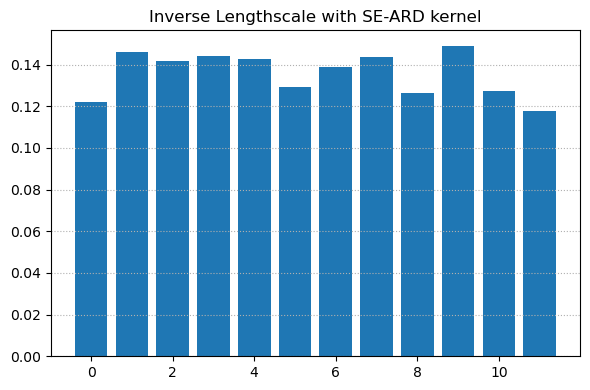

In [ ]:
# ------------------- Inverse Lengthscale plot ---------------------
plt.figure(figsize=(6, 4))
inv_lscale = safe_exp(log_alpha.detach())
plt.bar(torch.arange(Q).cpu(), inv_lscale.cpu())
plt.title("Inverse Lengthscale with SE-ARD kernel")
plt.grid(True, axis='y', ls=':')
plt.tight_layout()
plt.show()

['DataTrn.txt', 'DataTrnFrctns.txt', 'DataTrnLbls.txt', 'DataTst.txt', 'DataTstFrctns.txt', 'DataTstLbls.txt', 'DataVdn.txt', 'DataVdnFrctns.txt', 'DataVdnLbls.txt']
tensor(-2.0021, grad_fn=<MinBackward1>) tensor(-1.9974, grad_fn=<MaxBackward1>)


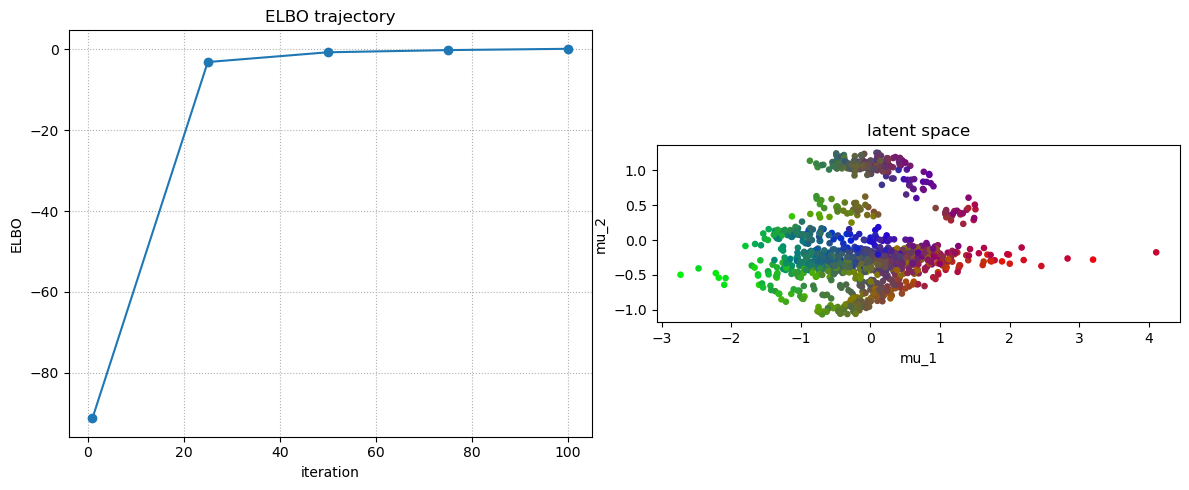

In [3]:
with tarfile.open(arc) as tar:
    print(tar.getnames())
    tar.extract("DataTrnFrctns.txt", path=root)

w   = np.loadtxt(root / "DataTrnFrctns.txt")                  # (N, 2)
print(log_alpha.min(), log_alpha.max())  # (-2.0, -2.0)

w3 = np.ones((w.shape[0],1)) - w.sum(axis=1, keepdims=True)  # (N, 1)
w = np.concatenate((w, w3), axis=1)                        # (N, 3)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(iters, elbo_hist, "-o")
plt.grid(ls=":")
plt.xlabel("iteration"); plt.ylabel("ELBO"); plt.title("ELBO trajectory")

plt.subplot(1, 2, 2)
plt.scatter(mu_x.detach().cpu()[:, 0],
            mu_x.detach().cpu()[:, 1],
            c=w, s=14)
plt.gca().set_aspect("equal")
plt.title("latent space")
plt.xlabel("mu_1"); plt.ylabel("mu_2")
plt.tight_layout(); plt.show()